In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression

from src.backtesting import *
from src.trading import *
from src.laplacian_estimators import *
from src.preprocessing import *

In [2]:
def sharpe_ratio(x):
    return x.mean() / x.std() * np.sqrt(12)

def sortino_ratio(x):
    mean = x.mean()
    std_neg = x[x<0].std()
    return mean / std_neg * np.sqrt(12)

# Load Data

## Load Stocks Data

In [3]:
# SP500 Data
prices = pd.read_csv("./data/sp500_prices_long.csv", parse_dates=['Date'])
prices['month'] = prices['Date'].dt.month
prices['year'] = prices['Date'].dt.year
raw_monthly_prices = prices.groupby(['year', 'month']).last().reset_index()
raw_monthly_prices['year_month'] = raw_monthly_prices['year'].astype(str) + ('00' + raw_monthly_prices['month'].astype(str)).str[-2:]
raw_monthly_prices = raw_monthly_prices.set_index('year_month').drop(columns=['year', 'month', 'Date'])
monthly_prices = raw_monthly_prices.loc[:, raw_monthly_prices.isna().mean(axis=0) < .5]
monthly_log_returns = np.log(monthly_prices).diff().iloc[1:]
monthly_log_returns = np.exp(monthly_log_returns) - 1
monthly_log_returns.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WST,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
year_month,,,,,,,,,,,,,,,,,,,,,
199502,NaN,NaN,NaN,-0.018981,NaN,0.555556,0.003533,NaN,0.235421,0.168606,...,-0.037036,0.075907,NaN,-0.021621,0.034362,-0.049999,NaN,NaN,-0.090625,0.059603
199503,NaN,NaN,NaN,-0.107596,NaN,-0.171429,0.007043,NaN,0.385995,0.014925,...,-0.019232,-0.046012,NaN,-0.027624,0.043053,0.047373,NaN,NaN,0.127148,-0.048934
199504,NaN,NaN,NaN,0.085107,NaN,0.206897,0.107499,NaN,0.176768,0.053921,...,0.102896,0.080386,NaN,0.020997,0.043151,0.014389,NaN,NaN,0.118902,0.129139
199505,NaN,NaN,NaN,0.089615,0.028249,-0.028571,0.015873,NaN,-0.107296,0.158139,...,0.004465,0.054687,NaN,0.070621,0.037924,0.021277,NaN,NaN,-0.019073,0.061584
199506,NaN,NaN,NaN,0.117294,0.002747,0.014706,0.012500,NaN,0.115385,0.092370,...,-0.004445,0.074074,NaN,-0.026385,-0.010507,0.002102,NaN,NaN,0.183333,0.112762


## Load Factors Data

In [4]:
factors = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors = factors.set_index('Date')
factors = factors.astype(np.float64)
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
202205,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,9.57,1.88,-4.10,0.68,-6.94,0.08


## Marge Indexes

In [5]:
idx = monthly_log_returns.merge(factors, right_index=True, left_index=True).index
monthly_log_returns = monthly_log_returns.loc[idx]
factors = factors.loc[idx]

## Remove Risk-free Returns

In [6]:
monthly_log_returns_rf = monthly_log_returns - factors[['RF']].values / 100
factors_rf = factors.drop(columns='RF')

# Backtest Strategies

In [7]:
split_window_size = 36
config_backtesters = dict()

In [8]:
# Identity
config_backtesters['NoPreprocessing Identity'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianIdentityLaplacianEstimator()),
    split_window_size=split_window_size
)

config_backtesters['Residuals Identity'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianIdentityLaplacianEstimator()),
    split_window_size=split_window_size
)

# Corr-50
config_backtesters['NoPreprocessing Corr-50'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianCorrKLaplacianEstimator(k=50)),
    split_window_size=split_window_size
)

config_backtesters['Residuals Corr-50'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianCorrKLaplacianEstimator(k=50)),
    split_window_size=split_window_size
)

# LGMRF
config_backtesters['NoPreprocessing LGMRF'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(max_iter=700)),
    split_window_size=split_window_size
)

config_backtesters['NoPreprocessing LGMRF uniform-weighting'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(max_iter=700, weights='uniform')),
    split_window_size=split_window_size
)

config_backtesters['Residuals LGMRF'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(max_iter=700)),
    split_window_size=split_window_size
)

config_backtesters['Residuals LGMRF uniform-weighting'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(max_iter=700, weights='uniform')),
    split_window_size=split_window_size
)

# LTMRF
config_backtesters['NoPreprocessing LTMRF'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(distribution='student', max_iter=700)),
    split_window_size=split_window_size
)

config_backtesters['NoPreprocessing LTMRF uniform-weighting'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(distribution='student', max_iter=700, weights='uniform')),
    split_window_size=split_window_size
)

config_backtesters['Residuals LTMRF'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(distribution='student', max_iter=700)),
    split_window_size=split_window_size
)

config_backtesters['Residuals LTMRF uniform-weighting'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTradingRule(laplacian_estimator=LaplacianGraphLearningLaplacianEstimator(distribution='student', max_iter=700, weights='uniform')),
    split_window_size=split_window_size
)

# Pairs-5
config_backtesters['NoPreprocessing Pairs-5'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=PairsDistanceTradingRule(5),
    split_window_size=split_window_size
)

config_backtesters['Residuals Pairs-5'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=PairsDistanceTradingRule(5),
    split_window_size=split_window_size
)

# Pairs-20
config_backtesters['NoPreprocessing Pairs-20'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=PairsDistanceTradingRule(20),
    split_window_size=split_window_size
)

config_backtesters['Residuals Pairs-20'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=PairsDistanceTradingRule(20),
    split_window_size=split_window_size
)

backtester = GridBacktester(config_backtesters, verbose=True)

In [9]:
config_returns = backtester.backtest(monthly_log_returns)
config_returns

 50%|█████     | 8/16 [09:17<14:32, 109.12s/it]C:\Users\miche\OneDrive\Desktop\Statistical Arbitrage via Graph Laplacians\StatisticalArbitrage\src\laplacian_estimators_folder\graph_learning_algorithm.py:374: RuntimeWarning: invalid value encountered in double_scalars
  error = np.linalg.norm(Lwi - Lw, 'fro') / np.linalg.norm(Lw, 'fro')
C:\Users\miche\OneDrive\Desktop\Statistical Arbitrage via Graph Laplacians\StatisticalArbitrage\src\laplacian_estimators_folder\graph_learning_algorithm.py:374: RuntimeWarning: divide by zero encountered in double_scalars
  error = np.linalg.norm(Lwi - Lw, 'fro') / np.linalg.norm(Lw, 'fro')
 56%|█████▋    | 9/16 [11:44<14:06, 120.93s/it]C:\Users\miche\OneDrive\Desktop\Statistical Arbitrage via Graph Laplacians\StatisticalArbitrage\src\laplacian_estimators_folder\graph_learning_algorithm.py:374: RuntimeWarning: invalid value encountered in double_scalars
  error = np.linalg.norm(Lwi - Lw, 'fro') / np.linalg.norm(Lw, 'fro')
C:\Users\miche\OneDrive\Desktop\

,NoPreprocessing Identity,Residuals Identity,NoPreprocessing Corr-50,Residuals Corr-50,NoPreprocessing LGMRF,NoPreprocessing LGMRF uniform-weighting,Residuals LGMRF,Residuals LGMRF uniform-weighting,NoPreprocessing LTMRF,NoPreprocessing LTMRF uniform-weighting,Residuals LTMRF,Residuals LTMRF uniform-weighting,NoPreprocessing Pairs-5,Residuals Pairs-5,NoPreprocessing Pairs-20,Residuals Pairs-20
200002,0.218490,-0.061569,0.213944,-0.071594,0.219397,0.156396,-0.071231,-0.057290,0.132103,0.166466,-0.070148,-0.058969,0.041171,0.000000,0.095170,-0.019280
200003,-0.028094,0.058977,-0.014448,0.063406,0.020805,-0.008768,0.059077,0.068137,0.011143,0.028299,0.062600,0.066568,0.000000,0.000000,0.053556,0.202062
200004,0.012771,0.091912,0.058245,0.085951,0.035185,0.031793,0.097030,0.109638,0.038409,0.024590,0.055030,0.090394,-0.119881,0.034462,-0.002095,0.054314
200005,0.097327,0.050206,0.033819,0.022967,0.040915,0.063935,0.014074,0.023195,0.021385,0.021480,-0.014304,-0.025045,0.090805,0.134427,0.087333,-0.012089
200006,0.074534,0.015398,0.081190,0.020721,0.085916,0.083566,0.049420,0.046972,0.075104,0.096974,0.049711,0.045726,-0.052142,0.013360,0.002551,-0.011573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202009,-0.038885,-0.036640,-0.034292,-0.037123,-0.041028,-0.033569,-0.019377,-0.011830,-0.016941,0.000000,0.006237,0.000000,0.020101,0.062876,0.035967,0.027457
202010,0.061455,0.160808,0.105052,0.146839,0.043132,0.077319,0.111040,0.130989,0.044124,0.000000,0.014302,0.000000,-0.007011,-0.015603,-0.000162,0.012458
202011,-0.004290,0.024263,0.002261,0.024622,0.001608,-0.002501,0.029497,0.026055,0.009474,0.000000,0.026894,0.000000,0.023213,0.000000,0.012874,0.011871
202012,0.009409,0.027442,0.008732,0.033659,0.008812,0.004960,0.030754,0.030530,0.003014,0.000000,0.028698,0.000000,0.000000,-0.022156,-0.033441,0.000000


In [30]:
config_returns.to_csv('results/config_returns.csv')

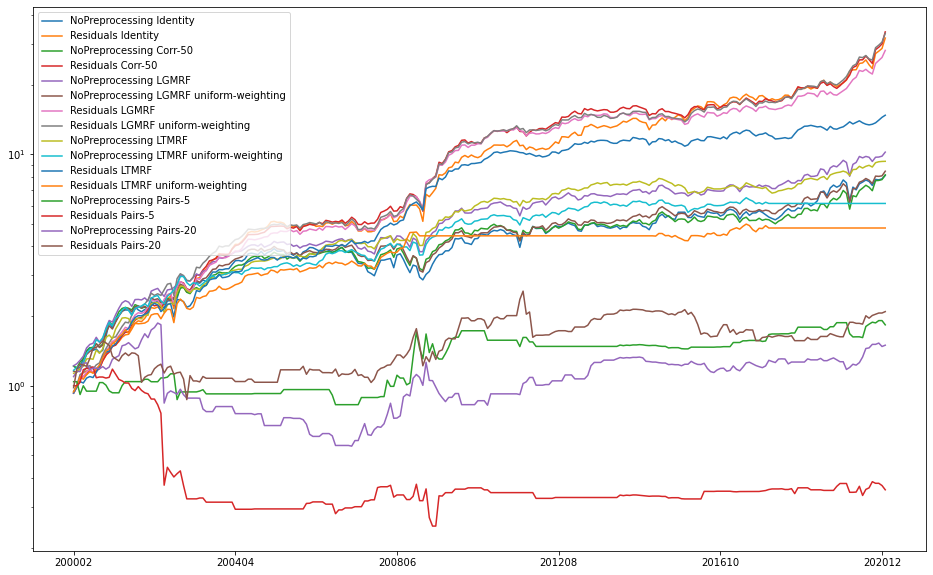

In [28]:
fig, ax = plt.subplots(figsize=(16, 10))
(1 + config_returns).cumprod().plot(ax=ax)
ax.set_yscale('log')
plt.show()

In [12]:
config_returns.corr()

,NoPreprocessing Identity,Residuals Identity,NoPreprocessing Corr-50,Residuals Corr-50,NoPreprocessing LGMRF,NoPreprocessing LGMRF uniform-weighting,Residuals LGMRF,Residuals LGMRF uniform-weighting,NoPreprocessing LTMRF,NoPreprocessing LTMRF uniform-weighting,Residuals LTMRF,Residuals LTMRF uniform-weighting,NoPreprocessing Pairs-5,Residuals Pairs-5,NoPreprocessing Pairs-20,Residuals Pairs-20
NoPreprocessing Identity,1.000000,0.325875,0.940768,0.308325,0.904140,0.925939,0.271221,0.304142,0.724372,0.704422,0.149542,0.137550,0.197598,0.158452,0.174486,0.040341
Residuals Identity,0.325875,1.000000,0.388903,0.938402,0.362059,0.385067,0.915659,0.939773,0.440169,0.327188,0.787012,0.557574,0.062973,0.170135,0.105280,0.227921
NoPreprocessing Corr-50,0.940768,0.388903,1.000000,0.416985,0.945681,0.962460,0.381621,0.407315,0.791371,0.740292,0.247593,0.185821,0.223221,0.182239,0.213694,0.091461
Residuals Corr-50,0.308325,0.938402,0.416985,1.000000,0.408270,0.430484,0.960737,0.971286,0.490928,0.356115,0.824419,0.594027,0.059977,0.179037,0.121683,0.238381
NoPreprocessing LGMRF,0.904140,0.362059,0.945681,0.408270,1.000000,0.957319,0.400222,0.411033,0.843973,0.820197,0.295843,0.222444,0.196259,0.230678,0.245919,0.124206
NoPreprocessing LGMRF uniform-weighting,0.925939,0.385067,0.962460,0.430484,0.957319,1.000000,0.402217,0.418660,0.798856,0.749596,0.271715,0.220460,0.183400,0.191288,0.190407,0.079888
Residuals LGMRF,0.271221,0.915659,0.381621,0.960737,0.400222,0.402217,1.000000,0.973712,0.517142,0.388824,0.882049,0.667298,0.039957,0.152253,0.102248,0.243162
Residuals LGMRF uniform-weighting,0.304142,0.939773,0.407315,0.971286,0.411033,0.418660,0.973712,1.000000,0.496891,0.374071,0.841360,0.631775,0.021104,0.150242,0.121957,0.243968
NoPreprocessing LTMRF,0.724372,0.440169,0.791371,0.490928,0.843973,0.798856,0.517142,0.496891,1.000000,0.861358,0.480386,0.356777,0.143327,0.267310,0.318778,0.150156
NoPreprocessing LTMRF uniform-weighting,0.704422,0.327188,0.740292,0.356115,0.820197,0.749596,0.388824,0.374071,0.861358,1.000000,0.368846,0.293464,0.179483,0.198182,0.263900,0.153725


In [13]:
def one_factor_alpha(x):
    return LinearRegression().fit(factors_rf[['Mkt-RF']].loc[x.index], x).intercept_

def five_factors_alpha(x):
    return LinearRegression().fit(factors_rf.loc[x.index], x).intercept_

In [15]:
results_df = config_returns.apply(lambda x: pd.Series(
    {'mean': np.mean(x), 'std': np.std(x),
     'sharpe': sharpe_ratio(x), 'sortino': sortino_ratio(x),
     '1-factor alpha': one_factor_alpha(x), '5-factors alpha': five_factors_alpha(x)})).T.sort_index()

In [26]:
results_df.round(4).style.highlight_max()#.format()

,mean,std,sharpe,sortino,1-factor alpha,5-factors alpha
NoPreprocessing Corr-50,0.009100,0.039300,0.801200,1.425900,0.009200,0.009200
NoPreprocessing Identity,0.009300,0.044400,0.724500,1.281600,0.009500,0.009600
NoPreprocessing LGMRF,0.009900,0.036500,0.938500,1.659900,0.009800,0.009800
NoPreprocessing LGMRF uniform-weighting,0.009200,0.036900,0.859000,1.409200,0.009100,0.008900
NoPreprocessing LTMRF,0.009300,0.030200,1.069800,2.146600,0.009300,0.009300
NoPreprocessing LTMRF uniform-weighting,0.007600,0.029400,0.898300,1.576900,0.007500,0.007700
NoPreprocessing Pairs-20,0.003600,0.057300,0.215800,0.189100,0.003400,0.005300
NoPreprocessing Pairs-5,0.003500,0.048600,0.251700,0.236500,0.003600,0.003700
Residuals Corr-50,0.014800,0.040200,1.276200,2.668600,0.014700,0.013600
Residuals Identity,0.014700,0.042400,1.197200,2.324400,0.014600,0.013900


In [25]:
config_returns.apply(lambda x: pd.Series(
    {'mean': np.mean(x), 'std': np.std(x),
     'sharpe': sharpe_ratio(x), 'sortino': sortino_ratio(x),
     '1-factor alpha': one_factor_alpha(x), '5-factors alpha': five_factors_alpha(x)})).T.sort_index()

,mean,std,sharpe,sortino,1-factor alpha,5-factors alpha
NoPreprocessing Corr-50,0.009323,0.038114,0.845695,1.572450,0.009683,0.009675
NoPreprocessing Identity,0.009185,0.043480,0.730360,1.423464,0.009655,0.010066
NoPreprocessing LGMRF,0.009549,0.035971,0.917851,1.661683,0.009701,0.010177
Residuals Corr-50,0.013065,0.040888,1.104758,1.705886,0.013270,0.011230
Residuals Identity,0.013997,0.045057,1.074059,1.709313,0.014167,0.011881
Residuals LGMRF,0.012358,0.040806,1.047076,1.519198,0.012509,0.010232


In [9]:
config_backtesters_pairs = dict()
config_backtesters_pairs['NoPreprocessing Pairs-5'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=PairsDistanceTradingRule(5),
    split_window_size=split_window_size
)

config_backtesters_pairs['Residuals Pairs-5'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=PairsDistanceTradingRule(5),
    split_window_size=split_window_size
)

config_backtesters_pairs['NoPreprocessing Pairs-20'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=PairsDistanceTradingRule(20),
    split_window_size=split_window_size
)

config_backtesters_pairs['Residuals Pairs-20'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=PairsDistanceTradingRule(20),
    split_window_size=split_window_size
)

backtester_pairs = GridBacktester(config_backtesters_pairs, verbose=True)
config_returns_pairs = backtester_pairs.backtest(monthly_log_returns)
config_returns_pairs

100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


,NoPreprocessing Pairs-5,Residuals Pairs-5,NoPreprocessing Pairs-20,Residuals Pairs-20
200002,0.041171,-0.151391,0.095170,-0.050242
200003,0.000000,0.077635,0.053556,0.207151
200004,-0.119881,0.034462,-0.002095,0.054314
200005,0.090805,0.000000,0.087333,-0.041960
200006,-0.052142,-0.016309,0.002551,0.003947
...,...,...,...,...
202109,0.000000,0.000000,0.000000,-0.010380
202110,0.000000,0.002762,0.043948,0.054954
202111,0.000000,0.017748,0.012804,0.107308
202112,0.012878,0.028951,0.019667,0.036028


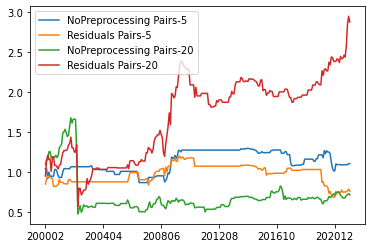

,NoPreprocessing Pairs-5,Residuals Pairs-5,NoPreprocessing Pairs-20,Residuals Pairs-20
NoPreprocessing Pairs-5,1.000000,0.128885,0.180782,0.071880
Residuals Pairs-5,0.128885,1.000000,0.020645,0.143061
NoPreprocessing Pairs-20,0.180782,0.020645,1.000000,0.561557
Residuals Pairs-20,0.071880,0.143061,0.561557,1.000000


In [12]:
(1 + config_returns_pairs).cumprod().plot()
plt.show()

config_returns_pairs.corr()

In [16]:
config_returns_pairs.apply(lambda x: pd.Series(
    {'expected return yoy': np.exp(np.mean(np.log(1+x)) * 12) - 1, 'std': np.std(x),
     'sharpe': sharpe_ratio(x), 'sortino': sortino_ratio(x),
     '1-factor alpha': one_factor_alpha(x), '5-factors alpha': five_factors_alpha(x)})).T.sort_index()

,expected return yoy,std,sharpe,sortino,1-factor alpha,5-factors alpha
NoPreprocessing Pairs-20,-0.015280,0.056087,0.056448,0.043012,-0.000055,0.002745
NoPreprocessing Pairs-5,0.004550,0.024642,0.095539,0.080593,0.000920,0.000908
Residuals Pairs-20,0.049191,0.059612,0.355927,0.305951,0.005630,0.008288
Residuals Pairs-5,-0.012447,0.027557,-0.081738,-0.056364,-0.000831,-0.001737
